### Load and Explore Data from Yahoo Finance

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to fetch stable stock data
def fetch_stock_data(ticker='KO', period='3y', interval='1d'):
    print(f"Fetching {ticker} data for period: {period} at {interval} interval")
    stock = yf.Ticker(ticker)
    df = stock.history(period=period, interval=interval)
    df = df.reset_index()
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return df


stock_df = fetch_stock_data()



Fetching KO data for period: 3y at 1d interval


In [2]:
# Quick overview
print(f"\nShape: {stock_df.shape}")
print("\nFirst few rows:")
print(stock_df.head())


Shape: (754, 5)

First few rows:
                                open       high        low      close  \
date                                                                    
2022-04-18 00:00:00-04:00  59.193593  59.568297  58.654393  58.892010   
2022-04-19 00:00:00-04:00  58.946837  59.632265  58.892005  59.467762   
2022-04-20 00:00:00-04:00  59.805916  60.537035  59.769359  60.281143   
2022-04-21 00:00:00-04:00  60.299423  61.231602  60.061806  60.509617   
2022-04-22 00:00:00-04:00  60.390806  60.628416  59.568290  59.632263   

                             volume  
date                                 
2022-04-18 00:00:00-04:00  11679400  
2022-04-19 00:00:00-04:00  11993800  
2022-04-20 00:00:00-04:00  14827100  
2022-04-21 00:00:00-04:00  15120400  
2022-04-22 00:00:00-04:00  14902200  


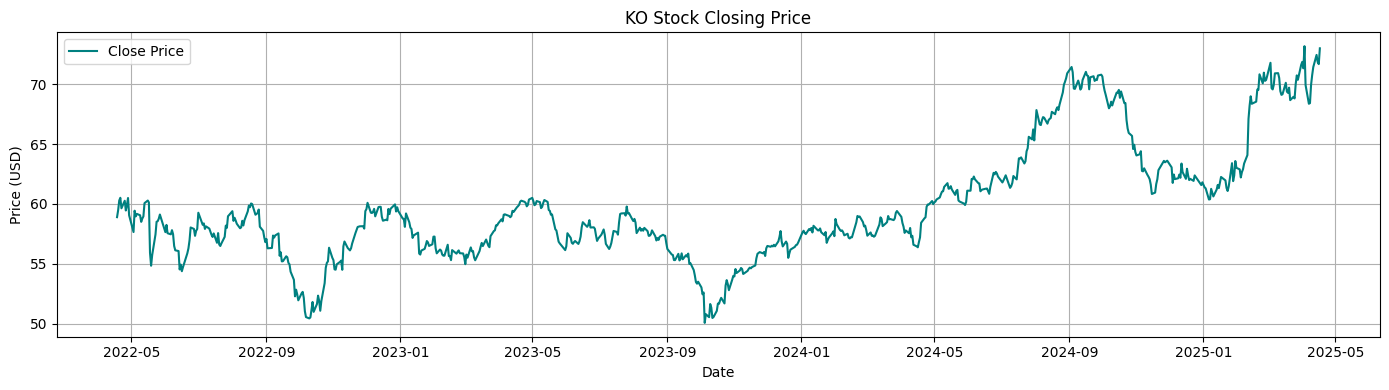

In [3]:
# Plot closing price
plt.figure(figsize=(14, 4))
plt.plot(stock_df.index, stock_df['close'], label='Close Price', color='teal')
plt.title("KO Stock Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Preprocessing + Feature Engineering

In [4]:
# Ensure the 'date' is the index, then clean the datetime format
if stock_df.index.name == 'date':
    # Remove timezone information from the datetime index
    stock_df.index = stock_df.index.tz_localize(None)

    # Sort the dataframe by the datetime index
    stock_df.sort_index(inplace=True)

    # Check if the datetime index is cleaned
    print("\nShape:", stock_df.shape)
    print("\nFirst few rows after cleaning:")
    print(stock_df.head())
else:
    print("\nThe 'date' column is not set as the index. Please check the DataFrame structure.")



Shape: (754, 5)

First few rows after cleaning:
                 open       high        low      close    volume
date                                                            
2022-04-18  59.193593  59.568297  58.654393  58.892010  11679400
2022-04-19  58.946837  59.632265  58.892005  59.467762  11993800
2022-04-20  59.805916  60.537035  59.769359  60.281143  14827100
2022-04-21  60.299423  61.231602  60.061806  60.509617  15120400
2022-04-22  60.390806  60.628416  59.568290  59.632263  14902200


In [5]:
# Feature engineering
stock_df['daily_return'] = stock_df['close'].pct_change()
stock_df['rolling_mean_7'] = stock_df['close'].rolling(window=7).mean()
stock_df['rolling_mean_15'] = stock_df['close'].rolling(window=15).mean()
stock_df['volatility_7'] = stock_df['daily_return'].rolling(window=7).std()
stock_df['lag_close_1'] = stock_df['close'].shift(1)

# Drop initial NA values from rolling operations
stock_df.dropna(inplace=True)



In [6]:
# Preview updated data
print("\nUpdated dataframe with features:")
print(stock_df.head())


Updated dataframe with features:
                 open       high        low      close    volume  \
date                                                               
2022-05-06  58.672663  59.687097  58.553858  59.166172  18984000   
2022-05-09  58.919425  59.732799  58.526446  59.047371  20055300   
2022-05-10  58.946835  59.696236  58.352795  58.499023  21322200   
2022-05-11  58.791475  59.586568  58.453328  58.773193  19648400   
2022-05-12  58.636109  58.974250  57.767896  58.955975  22574700   

            daily_return  rolling_mean_7  rolling_mean_15  volatility_7  \
date                                                                      
2022-05-06      0.003565       58.959895        59.408666      0.018418   
2022-05-09     -0.002008       58.753614        59.419024      0.017746   
2022-05-10     -0.009287       58.675278        59.354441      0.015664   
2022-05-11      0.004687       58.788863        59.253911      0.013832   
2022-05-12      0.003110       58.97555

### Train-Test Split

In [7]:
# Step 3: Train-test split
split_ratio = 0.8
split_index = int(len(stock_df) * split_ratio)

train_df = stock_df.iloc[:split_index]
test_df = stock_df.iloc[split_index:]

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (592, 10)
Test shape: (148, 10)


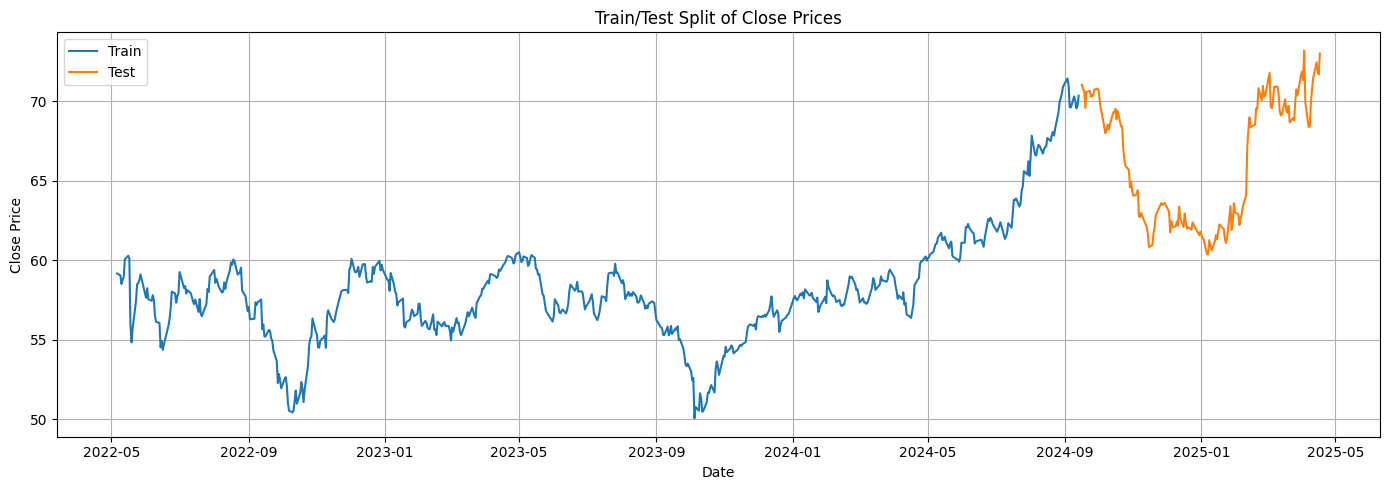

In [8]:
# plot to verify the split visually
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(train_df.index, train_df['close'], label='Train')
plt.plot(test_df.index, test_df['close'], label='Test')
plt.title("Train/Test Split of Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Model 1 — ARIMA (with log transformation)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA (log-transformed) Forecast Results:
MAE: 4.43
RMSE: 5.67
MAPE: 7.02%


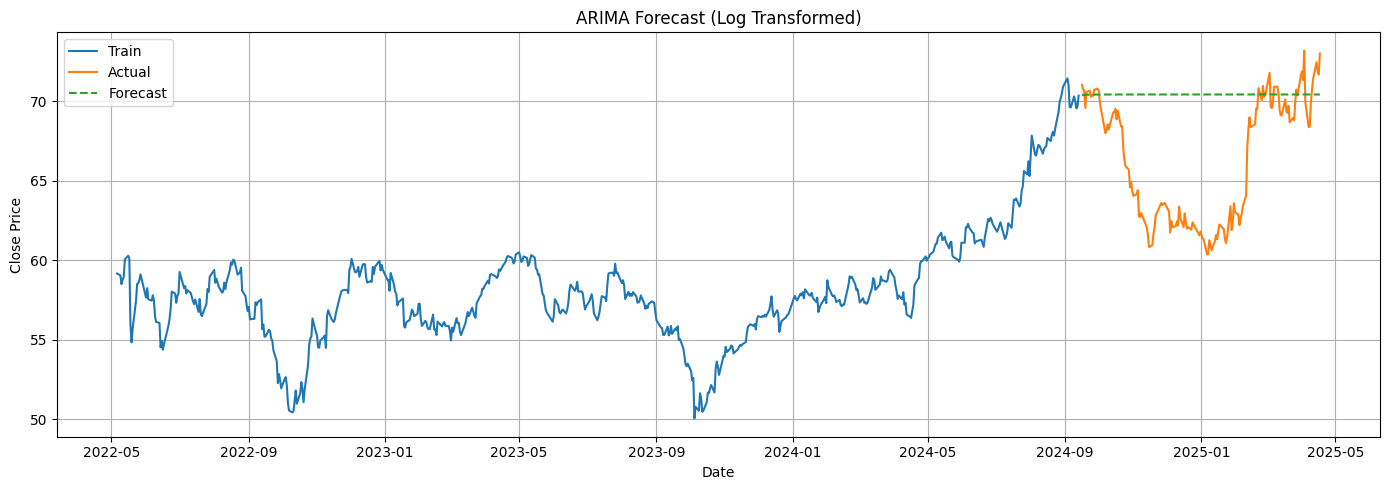

In [9]:
# Import necessary libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_df and test_df are already loaded with the stock data
# Use only the closing prices
train_close = train_df['close']
test_close = test_df['close']

# Apply log transformation
train_log = np.log(train_close)
test_log = np.log(test_close)

# Fit SARIMA on log-transformed data
arima_model = SARIMAX(train_log, order=(1,1,1), seasonal_order=(1,0,1,5), enforce_stationarity=False, enforce_invertibility=False)
arima_fitted = arima_model.fit(disp=False)

# Forecast in log scale
n_test = len(test_log)
forecast_log = arima_fitted.get_forecast(steps=n_test)
forecast_log_series = forecast_log.predicted_mean

# Reset indices to ensure alignment between actual and forecasted data
forecast_log_series = forecast_log_series.reset_index(drop=True)  # Reset index of the forecast series
test_close = test_close.reset_index(drop=True)  # Reset index of the test series

# Convert forecast back to normal scale
forecast = np.exp(forecast_log_series)

# Evaluation
mae = mean_absolute_error(test_close, forecast)
rmse = np.sqrt(mean_squared_error(test_close, forecast))

# Mask for non-zero values for MAPE calculation
non_zero_mask = test_close > 1e-3
mape = np.mean(np.abs((test_close[non_zero_mask] - forecast[non_zero_mask]) / test_close[non_zero_mask])) * 100

# Print results
print(f"ARIMA (log-transformed) Forecast Results:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Optional: plot forecast
plt.figure(figsize=(14,5))
plt.plot(train_df.index, train_df['close'], label='Train')
plt.plot(test_df.index, test_df['close'], label='Actual')
plt.plot(test_df.index, forecast, label='Forecast', linestyle='--')
plt.title("ARIMA Forecast (Log Transformed)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# Create a comparison DataFrame to display actual vs forecasted values
comparison_df = pd.DataFrame({
    'Date': test_df.index,
    'Actual Close': test_close,
    'Forecasted Close': forecast
})

# Set 'Date' as index for cleaner display
comparison_df.set_index('Date', inplace=True)

# Display first few rows
print("\nActual vs Forecasted Closing Prices:")
print(comparison_df.head(10))  # Change 10 to whatever number of rows you want to preview



Actual vs Forecasted Closing Prices:
            Actual Close  Forecasted Close
Date                                      
2024-09-16     71.033073         70.403343
2024-09-17     70.737518         70.409323
2024-09-18     70.688255         70.394058
2024-09-19     69.574982         70.384669
2024-09-20     70.579887         70.407751
2024-09-23     70.668556         70.420897
2024-09-24     70.274467         70.421148
2024-09-25     70.392693         70.414468
2024-09-26     70.343430         70.410558
2024-09-27     70.727669         70.419571


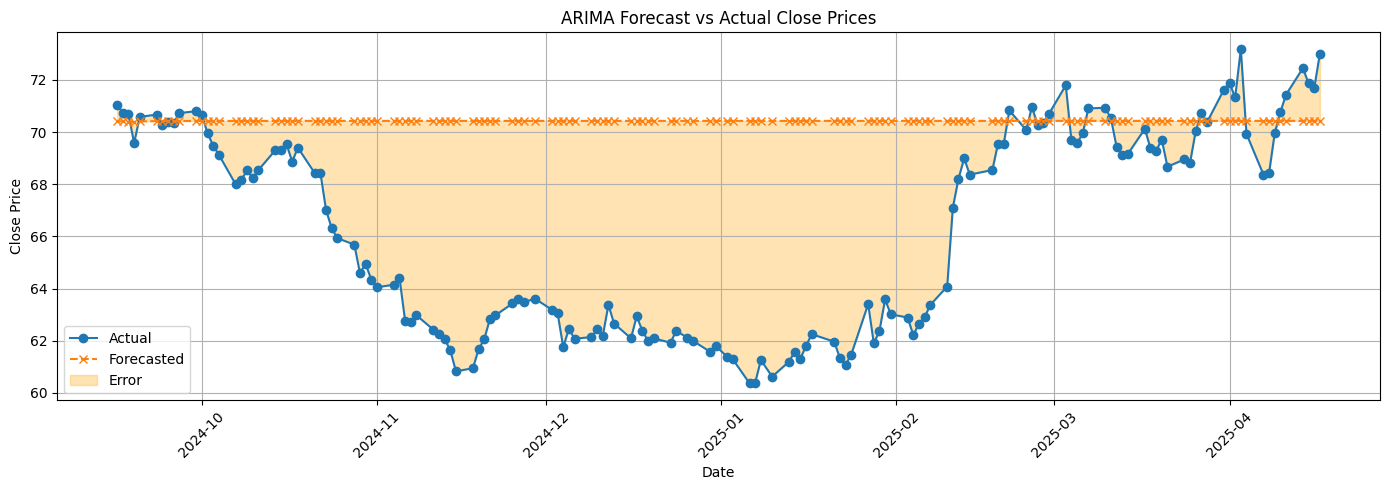

In [11]:
# Plot actual vs forecasted with error bars
plt.figure(figsize=(14,5))
plt.plot(comparison_df.index, comparison_df['Actual Close'], label='Actual', marker='o')
plt.plot(comparison_df.index, comparison_df['Forecasted Close'], label='Forecasted', marker='x', linestyle='--')
plt.fill_between(comparison_df.index,
                 comparison_df['Actual Close'],
                 comparison_df['Forecasted Close'],
                 color='orange', alpha=0.3, label='Error')
plt.xticks(rotation=45)
plt.title("ARIMA Forecast vs Actual Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


## Improved Walk-Forward Prediction(SARIMA)

<ipython-input-12-49a2264521c3>:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history_log.append(test_log_values[i])
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11

Short-Term Forecast Results:
MAE: 0.59
RMSE: 0.79
MAPE: 0.88%
Directional Accuracy (Short-Term): 47.62%

Long-Term Forecast Results:
MAE: 1.19
RMSE: 1.58
MAPE: 1.80%
Directional Accuracy (Long-Term): 45.77%


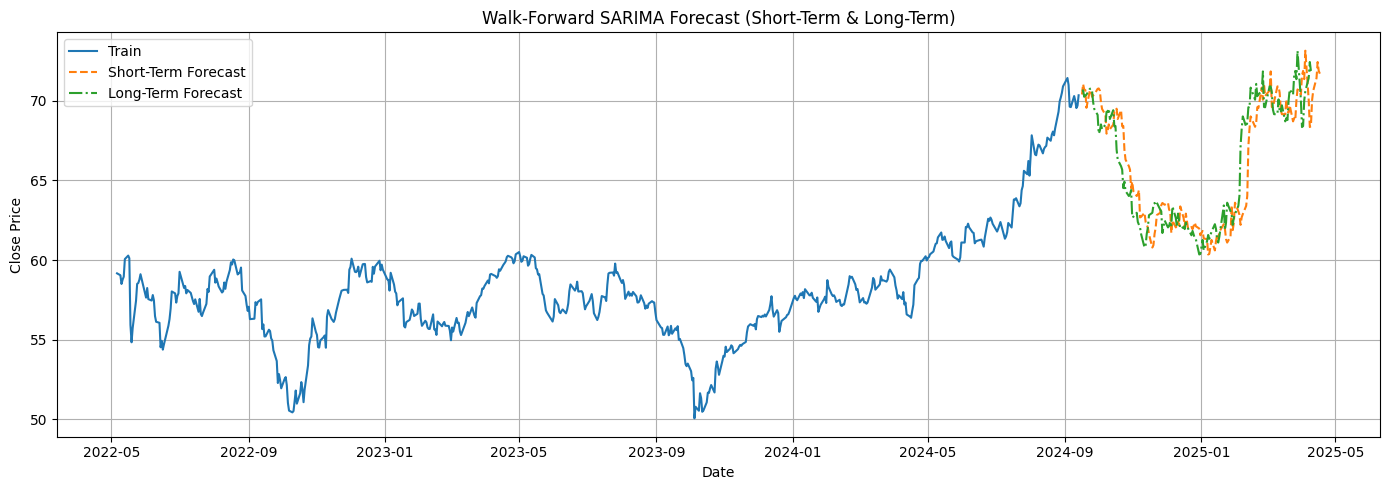


Actual vs Forecasted (Short-Term & Long-Term):
            Actual Close  Short-Term Forecasted Close  \
date                                                    
2024-09-23     70.668556                    70.632632   
2024-09-24     70.274467                    70.664760   
2024-09-25     70.392693                    70.258714   
2024-09-26     70.343430                    70.344979   
2024-09-27     70.727669                    70.392462   
2024-09-30     70.796623                    70.757701   
2024-10-01     70.648842                    70.781815   
2024-10-02     69.959206                    70.648655   
2024-10-03     69.476456                    69.919834   
2024-10-04     69.131630                    69.492458   

            Long-Term Forecasted Close  
date                                    
2024-09-23                   70.632632  
2024-09-24                   70.664760  
2024-09-25                   70.258714  
2024-09-26                   70.344979  
2024-09-27           

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ---- Step 1: Set up variables ----
train_log_values = np.log(train_df['close'])
test_log_values = np.log(test_df['close'])

# Store forecasts
rolling_log_preds_short_term = []
rolling_log_preds_long_term = []
history_log = list(train_log_values)

# ---- Step 2: Walk-forward prediction ----
for i in range(len(test_log_values)):
    model = SARIMAX(history_log, order=(1, 1, 1), seasonal_order=(1, 0, 1, 5),
                    enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)

    # Short-term forecast for 1 step
    forecast_next_log_short_term = result.forecast(steps=1)[0]
    rolling_log_preds_short_term.append(forecast_next_log_short_term)

    # Long-term forecast (forecasting multiple steps ahead)
    if i >= 5:  # Start long-term forecast after 5 steps to prevent drift from initial forecast
        forecast_next_log_long_term = result.forecast(steps=5)[0]  # Forecast next 5 steps
        rolling_log_preds_long_term.append(forecast_next_log_long_term)

    # Append actual log value to history
    history_log.append(test_log_values[i])

# ---- Step 3: Convert log forecast back to original scale ----
rolling_forecast_short_term = np.exp(rolling_log_preds_short_term)
rolling_forecast_long_term = np.exp(np.array(rolling_log_preds_long_term).flatten())

# ---- Step 4: Evaluate Short-Term Forecast ----
mae_short_term = mean_absolute_error(test_df['close'][:len(rolling_forecast_short_term)], rolling_forecast_short_term)
rmse_short_term = np.sqrt(mean_squared_error(test_df['close'][:len(rolling_forecast_short_term)], rolling_forecast_short_term))
mape_short_term = np.mean(np.abs((test_df['close'][:len(rolling_forecast_short_term)] - rolling_forecast_short_term) / test_df['close'][:len(rolling_forecast_short_term)])) * 100

# ---- Step 5: Evaluate Long-Term Forecast ----
# Ensure the long-term forecast is sliced to match the actual values.
long_term_forecast_len = len(test_df['close'][:len(rolling_forecast_long_term)])  # Length of actual values for long-term forecast
rolling_forecast_long_term = rolling_forecast_long_term[:long_term_forecast_len]  # Slice the forecast to match

# Now calculate the evaluation metrics for long-term forecast
mae_long_term = mean_absolute_error(test_df['close'][:long_term_forecast_len], rolling_forecast_long_term)
rmse_long_term = np.sqrt(mean_squared_error(test_df['close'][:long_term_forecast_len], rolling_forecast_long_term))
mape_long_term = np.mean(np.abs((test_df['close'][:long_term_forecast_len] - rolling_forecast_long_term) / test_df['close'][:long_term_forecast_len])) * 100

# ---- Step 6: Directional Accuracy ----
# Short-term directional accuracy
forecast_direction_short_term = np.sign(np.diff(rolling_forecast_short_term))  # 1 for up, -1 for down
actual_direction_short_term = np.sign(np.diff(test_df['close'][:len(rolling_forecast_short_term)]))  # 1 for up, -1 for down

# Long-term directional accuracy
forecast_direction_long_term = np.sign(np.diff(rolling_forecast_long_term))  # 1 for up, -1 for down
actual_direction_long_term = np.sign(np.diff(test_df['close'][:len(rolling_forecast_long_term)]))  # 1 for up, -1 for down

# Short-Term Directional Accuracy
directional_accuracy_short_term = np.mean(forecast_direction_short_term == actual_direction_short_term) * 100

# Long-Term Directional Accuracy
directional_accuracy_long_term = np.mean(forecast_direction_long_term == actual_direction_long_term) * 100

# ---- Step 7: Display Results ----
print("Short-Term Forecast Results:")
print(f"MAE: {mae_short_term:.2f}")
print(f"RMSE: {rmse_short_term:.2f}")
print(f"MAPE: {mape_short_term:.2f}%")
print(f"Directional Accuracy (Short-Term): {directional_accuracy_short_term:.2f}%")

print("\nLong-Term Forecast Results:")
print(f"MAE: {mae_long_term:.2f}")
print(f"RMSE: {rmse_long_term:.2f}")
print(f"MAPE: {mape_long_term:.2f}%")
print(f"Directional Accuracy (Long-Term): {directional_accuracy_long_term:.2f}%")

# ---- Step 8: Plot ----
plt.figure(figsize=(14, 5))
plt.plot(train_df.index, train_df['close'], label='Train')
plt.plot(test_df.index[:len(rolling_forecast_short_term)], rolling_forecast_short_term, label='Short-Term Forecast', linestyle='--')
plt.plot(test_df.index[:len(rolling_forecast_long_term)], rolling_forecast_long_term, label='Long-Term Forecast', linestyle='-.')
plt.title("Walk-Forward SARIMA Forecast (Short-Term & Long-Term)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Step 9: Show comparison table ----
# Use the length of the long-term forecast as the reference (shorter one)
num_forecast_points = len(rolling_forecast_long_term)

# Ensure all arrays have same length
actual_close_sliced = test_df['close'][5:5+num_forecast_points]  # Offset by 5 since long-term starts at i=5
short_term_forecast_sliced = rolling_forecast_short_term[5:5+num_forecast_points]
long_term_forecast_sliced = rolling_forecast_long_term[:num_forecast_points]
index_sliced = test_df.index[5:5+num_forecast_points]

# Now build the DataFrame with matched lengths and index
comparison_df = pd.DataFrame({
    'Actual Close': actual_close_sliced.values,
    'Short-Term Forecasted Close': short_term_forecast_sliced,
    'Long-Term Forecasted Close': long_term_forecast_sliced
}, index=index_sliced)


print("\nActual vs Forecasted (Short-Term & Long-Term):")
print(comparison_df.head(10))

### Residual Analysis for SARIMAX

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


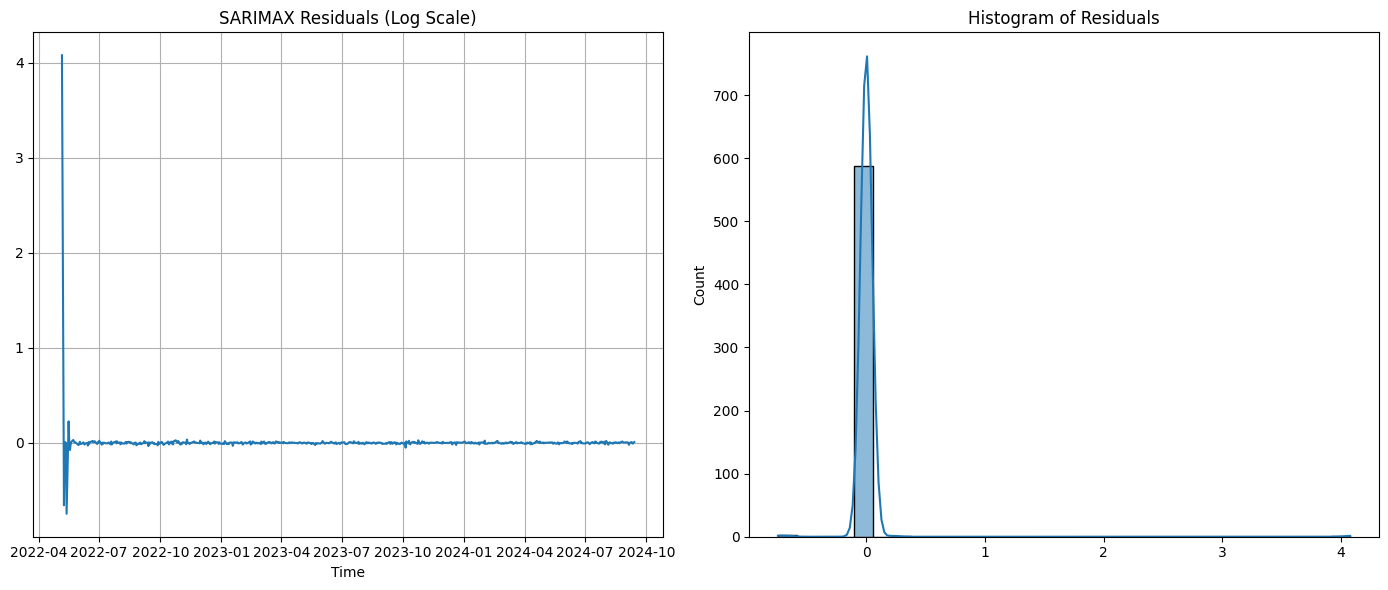

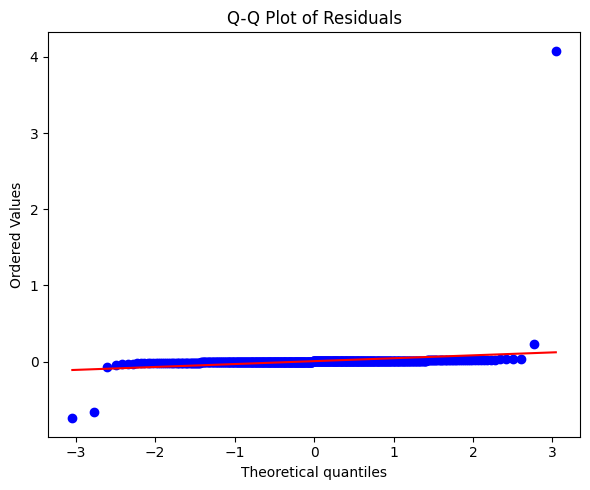

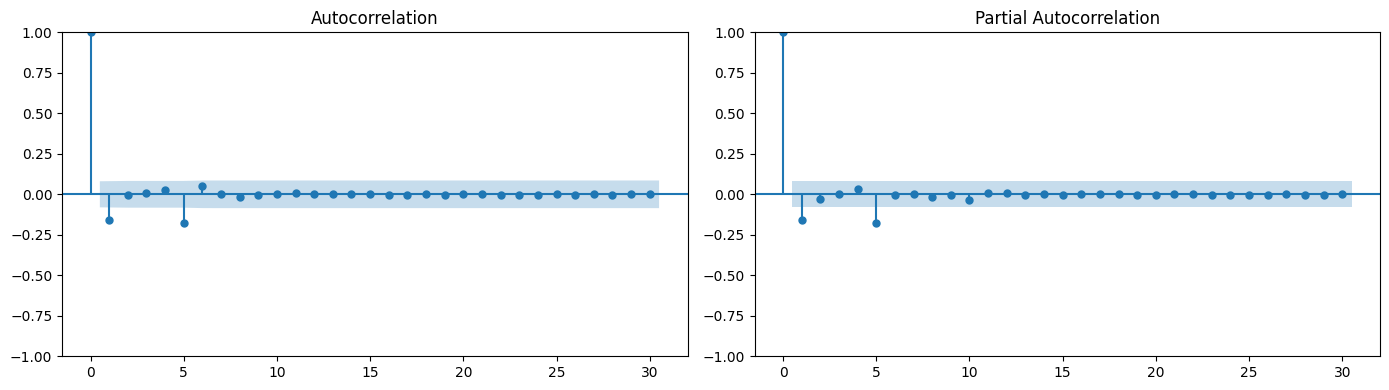

In [13]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats

# Fit SARIMAX on full training data for residual analysis
model_diag = SARIMAX(train_log_values, order=(1, 1, 1), seasonal_order=(1, 0, 1, 5),
                     enforce_stationarity=False, enforce_invertibility=False)
result_diag = model_diag.fit(disp=False)
residuals = result_diag.resid

# Plot residuals
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title("SARIMAX Residuals (Log Scale)")
plt.xlabel("Time")
plt.grid()

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, bins=30)
plt.title("Histogram of Residuals")
plt.tight_layout()
plt.show()

# Q-Q Plot
plt.figure(figsize=(6, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

# ACF and PACF plots
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(residuals, ax=ax[0], lags=30)
plot_pacf(residuals, ax=ax[1], lags=30)
plt.tight_layout()
plt.show()


## Model 2 - Holt-Winters

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Holt-Winters Forecast Results:
MAE: 5.52
RMSE: 6.66
MAPE: 8.68%


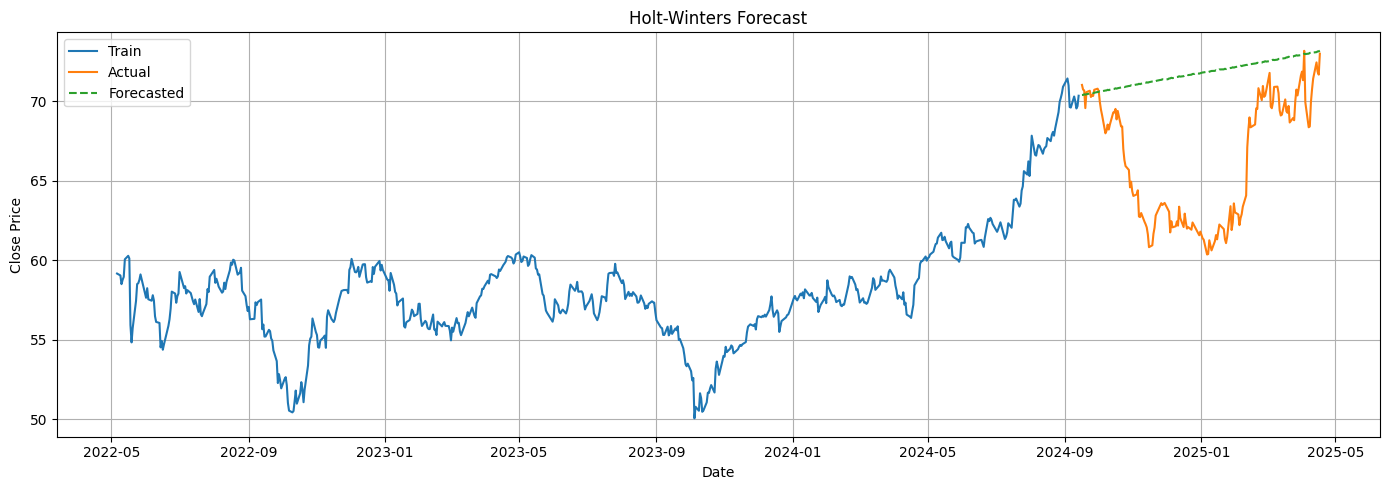

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Train and Test Data (using 'close' column)
train_close = train_df['close']
test_close = test_df['close']

# Fit the Holt-Winters model
holt_winters_model = ExponentialSmoothing(train_close, trend='add', seasonal='add', seasonal_periods=5)
holt_winters_fitted = holt_winters_model.fit()

# Forecast the test data
forecast_hw = holt_winters_fitted.forecast(len(test_close))

# Align indices to avoid masking issues
test_close_aligned = pd.Series(test_close.values, index=np.arange(len(test_close)))
forecast_hw_aligned = pd.Series(forecast_hw.values, index=np.arange(len(test_close)))

# Evaluation
mae_hw = mean_absolute_error(test_close_aligned, forecast_hw_aligned)
rmse_hw = np.sqrt(mean_squared_error(test_close_aligned, forecast_hw_aligned))

# MAPE calculation only for non-zero actuals
non_zero_mask_hw = test_close_aligned > 1e-3
mape_hw = np.mean(np.abs((test_close_aligned[non_zero_mask_hw] - forecast_hw_aligned[non_zero_mask_hw]) / test_close_aligned[non_zero_mask_hw])) * 100

# Print Results
print(f"Holt-Winters Forecast Results:")
print(f"MAE: {mae_hw:.2f}")
print(f"RMSE: {rmse_hw:.2f}")
print(f"MAPE: {mape_hw:.2f}%")

# Plotting
plt.figure(figsize=(14,5))
plt.plot(train_df.index, train_df['close'], label='Train')
plt.plot(test_df.index, test_df['close'], label='Actual')
plt.plot(test_df.index, forecast_hw, label='Forecasted', linestyle='--')
plt.title("Holt-Winters Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Walk-Forward Holt-Winters Forecast


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/


Walk-Forward Holt-Winters Results:
Short-Term:
MAE: 0.58, RMSE: 0.79, MAPE: 0.87%, Directional Accuracy: 48.30%
Long-Term (Improved):
MAE: 4.45, RMSE: 5.70, MAPE: 7.05%, Directional Accuracy: 54.42%


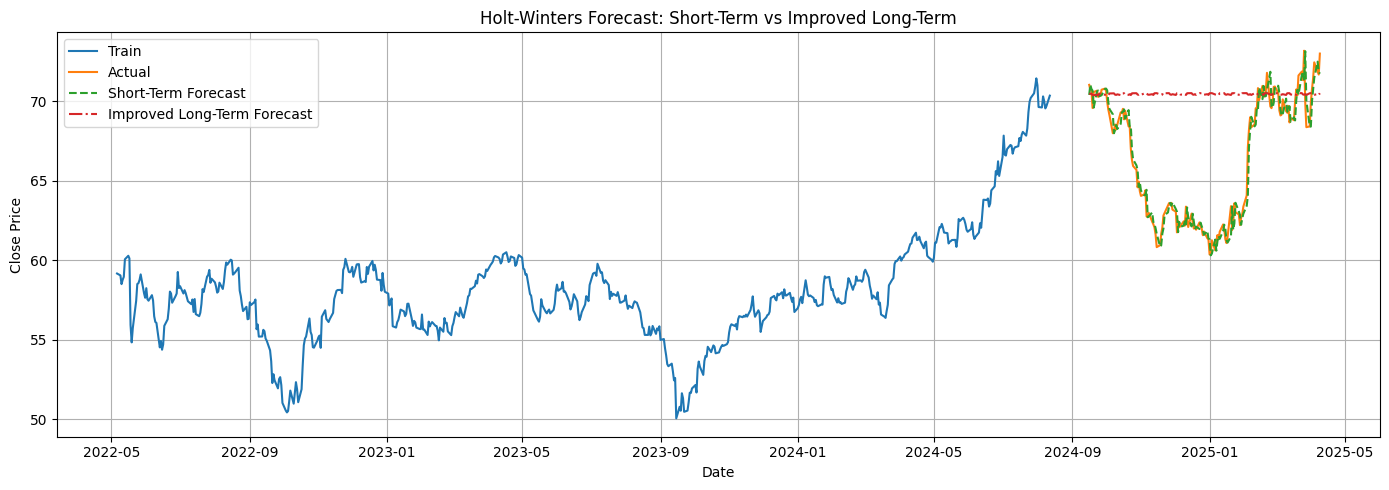

Holt-Winters forecast results saved to 'forecasted_results_hw.csv'


In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---- Prepare Close Prices ----
train_close = train_df['close'].copy()
test_close = test_df['close'].copy()

# Ensure datetime index with business day frequency
train_close.index = pd.date_range(start=train_close.index[0], periods=len(train_close), freq='B')
test_close.index = pd.date_range(start=test_close.index[0], periods=len(test_close), freq='B')

# ---- Short-Term Forecasting (Walk-forward 1-step) ----
walk_forecast_short_term = []

for i in range(len(test_close)):
    try:
        current_train = pd.concat([train_close, test_close.iloc[:i]])
        model = ExponentialSmoothing(current_train, trend='add', seasonal='add', seasonal_periods=5)
        fitted = model.fit()
        next_forecast = fitted.forecast(1).iloc[0]
        walk_forecast_short_term.append(next_forecast)
    except Exception as e:
        print(f"Short-Term Model failed at step {i}: {e}")
        walk_forecast_short_term.append(np.nan)

walk_forecast_short_term = pd.Series(walk_forecast_short_term, index=test_close.index)
walk_forecast_short_term = walk_forecast_short_term.ffill().bfill()

# ---- Improved Long-Term Forecasting (auto-optimized, damped trend, better seasonality) ----
try:
    model_long = ExponentialSmoothing(
        train_close,
        trend='add',
        damped_trend=True,
        seasonal='mul',
        seasonal_periods=7
    )
    fitted_long = model_long.fit(optimized=True)
    walk_forecast_long_term = fitted_long.forecast(len(test_close))
    walk_forecast_long_term.index = test_close.index
except Exception as e:
    print(f"Long-Term Model failed: {e}")
    walk_forecast_long_term = pd.Series(np.full(len(test_close), np.nan), index=test_close.index)

walk_forecast_long_term = walk_forecast_long_term.ffill().bfill()


# ---- Metric Computation ----
def compute_metrics(actual, predicted):
    actual, predicted = actual.align(predicted, join='inner')
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    non_zero_mask = actual > 1e-3
    mape = np.mean(np.abs((actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask])) * 100
    return mae, rmse, mape

def compute_directional_accuracy(actual, forecast):
    actual, forecast = actual.align(forecast, join='inner')
    actual_dir = np.sign(np.diff(actual))
    forecast_dir = np.sign(np.diff(forecast))
    return np.mean(actual_dir == forecast_dir) * 100

# ---- Evaluate ----
mae_short, rmse_short, mape_short = compute_metrics(test_close, walk_forecast_short_term)
mae_long, rmse_long, mape_long = compute_metrics(test_close, walk_forecast_long_term)
direction_short = compute_directional_accuracy(test_close, walk_forecast_short_term)
direction_long = compute_directional_accuracy(test_close, walk_forecast_long_term)

# ---- Print Results ----
print("\nWalk-Forward Holt-Winters Results:")
print("Short-Term:")
print(f"MAE: {mae_short:.2f}, RMSE: {rmse_short:.2f}, MAPE: {mape_short:.2f}%, Directional Accuracy: {direction_short:.2f}%")
print("Long-Term (Improved):")
print(f"MAE: {mae_long:.2f}, RMSE: {rmse_long:.2f}, MAPE: {mape_long:.2f}%, Directional Accuracy: {direction_long:.2f}%")

# ---- Plot Forecasts ----
plt.figure(figsize=(14,5))
plt.plot(train_close.index, train_close, label='Train')
plt.plot(test_close.index, test_close, label='Actual')
plt.plot(walk_forecast_short_term.index, walk_forecast_short_term, label='Short-Term Forecast', linestyle='--')
plt.plot(walk_forecast_long_term.index, walk_forecast_long_term, label='Improved Long-Term Forecast', linestyle='-.')
plt.title("Holt-Winters Forecast: Short-Term vs Improved Long-Term")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Save Results ----
forecast_results_hw = pd.DataFrame({
    'Actual Close': test_close.values,
    'Short-Term Forecasted Close': walk_forecast_short_term.values,
    'Improved Long-Term Forecasted Close': walk_forecast_long_term.values
}, index=test_close.index)

forecast_results_hw.to_csv('forecasted_results_hw.csv')
print("Holt-Winters forecast results saved to 'forecasted_results_hw.csv'")


## Prophet Forecasting

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcmx7rrje/j0s3uqi6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcmx7rrje/_p2hmzzx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62556', 'data', 'file=/tmp/tmpcmx7rrje/j0s3uqi6.json', 'init=/tmp/tmpcmx7rrje/_p2hmzzx.json', 'output', 'file=/tmp/tmpcmx7rrje/prophet_model_weruw3l/prophet_model-20250420093316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:33:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:33:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Forecast Evaluation:
MAE:  12.3909
RMSE: 13.7614
MAPE: 19.09%
Prophet forecast results have been saved to 'forecasted_results_prophet.csv'


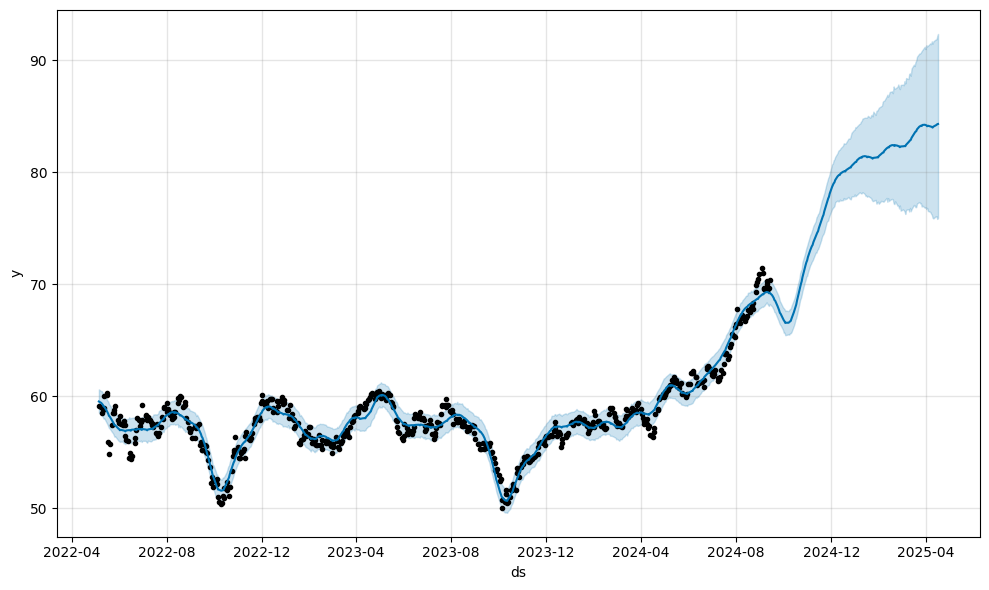

In [16]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Step 1: Prepare Data for Prophet
# Reset index to get 'date' column back and rename it to 'ds' and 'close' to 'y'
prophet_train_df = train_df.reset_index()[['date', 'close']].rename(columns={'date': 'ds', 'close': 'y'})
prophet_test_df = test_df.reset_index()[['date', 'close']].rename(columns={'date': 'ds', 'close': 'y'})

# Step 2: Fit Prophet Model
model = Prophet(daily_seasonality=True)
model.fit(prophet_train_df)

# Step 3: Create Future DataFrame
# Find the number of business days needed to cover the test period
last_train_date = prophet_train_df['ds'].max()
last_test_date = prophet_test_df['ds'].max()

# Generate correct number of business days for forecast
n_periods = len(pd.date_range(start=last_train_date + pd.Timedelta(days=1),
                              end=last_test_date, freq='B'))

# Create future dates
future_df = model.make_future_dataframe(periods=n_periods, freq='B')

# Step 4: Generate Forecast
forecast = model.predict(future_df)

# Step 5: Get forecasted values that match the test period
# Merge is safer than indexing
forecast_test = pd.merge(prophet_test_df, forecast[['ds', 'yhat']], on='ds', how='inner')

# Step 6: Evaluate
mae = mean_absolute_error(forecast_test['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(forecast_test['y'], forecast_test['yhat']))
mape = np.mean(np.abs((forecast_test['y'] - forecast_test['yhat']) / forecast_test['y'])) * 100

# Step 7: Print Evaluation
print(f"Prophet Forecast Evaluation:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# Optional: Plot forecast
model.plot(forecast)

# Step 8: Save the forecasted results to a CSV file
forecast_results_prophet = pd.DataFrame({
    'True Values': forecast_test['y'].values,
    'Predicted Values': forecast_test['yhat'].values
})

# Save to CSV
forecast_results_prophet.to_csv('forecasted_results_prophet.csv', index=False)

print("Prophet forecast results have been saved to 'forecasted_results_prophet.csv'")


## Model 3 - LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0514 - val_loss: 0.0036
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070 - val_loss: 0.0016
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020 - val_loss: 0.0062
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - val_loss: 0.0049
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020 - val_loss: 0.0060
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

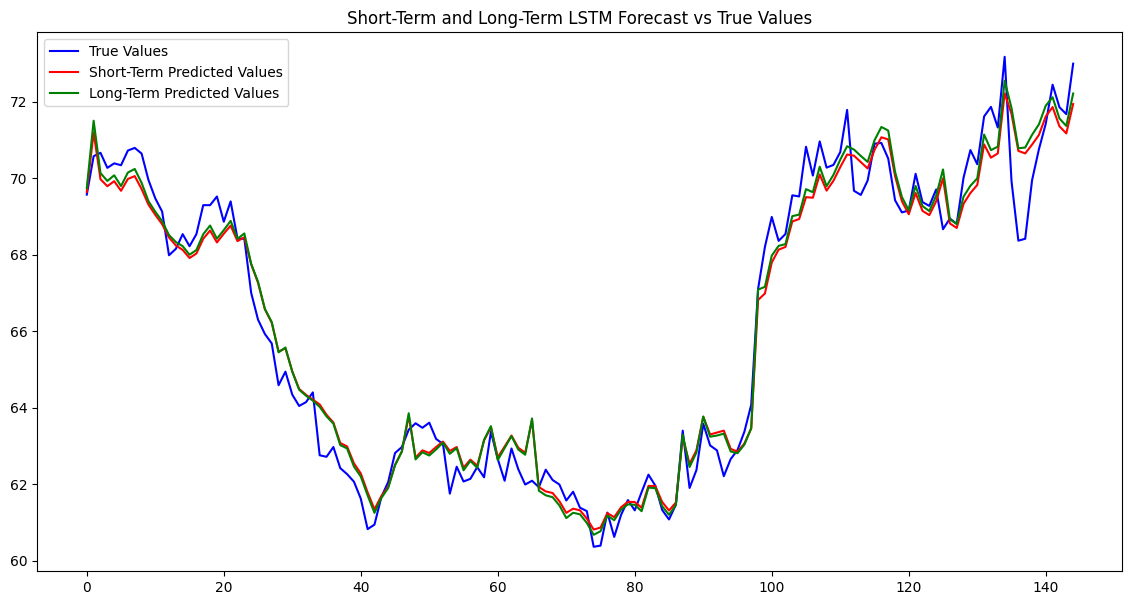

Forecast results have been saved to 'forecasted_results_lstm_separated.csv'


In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# -------------------------
# Create lagged features
# -------------------------
def create_lagged_features(df, lags=3):
    df_lagged = df.copy()
    for i in range(1, lags + 1):
        df_lagged[f'lag_{i}'] = df_lagged['close'].shift(i)
    df_lagged.dropna(inplace=True)
    return df_lagged

train_lagged_df = create_lagged_features(train_df, lags=3)
test_lagged_df = create_lagged_features(test_df, lags=3)

# -------------------------
# Prepare features and targets
# -------------------------
train_features = train_lagged_df.drop(columns=['close'])
test_features = test_lagged_df.drop(columns=['close'])

train_features, test_features = train_features.align(test_features, join='left', axis=1)

# -------------------------
# Scale the features
# -------------------------
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform on training features
X_train_scaled = scaler.fit_transform(train_features)

# Only transform on test features (use the same scaler)
X_test_scaled = scaler.transform(test_features)

# Scale the target variable (close) for both train and test sets
y_train_scaled = scaler.fit_transform(train_lagged_df[['close']])
y_test_scaled = scaler.transform(test_lagged_df[['close']])

# -------------------------
# Reshape data for LSTM
# -------------------------
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# -------------------------
# Define LSTM Model
# -------------------------
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
    model.add(Dropout(0.3))  # Increased dropout to prevent overfitting
    model.add(LSTM(units=150, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# -------------------------
# Implement Early Stopping
# -------------------------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# -------------------------
# Train and Predict Short-Term (1-7 days) Model
# -------------------------
# Train short-term model (first 7 days)
train_short_term = train_lagged_df.iloc[:7]
test_short_term = test_lagged_df.iloc[:7]

short_term_model = build_lstm_model()
short_term_model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stopping])

short_term_predictions = short_term_model.predict(X_test_scaled)

# -------------------------
# Train and Predict Long-Term (8-30 days) Model
# -------------------------
# Train long-term model (8-30 days)
train_long_term = train_lagged_df.iloc[7:30]
test_long_term = test_lagged_df.iloc[7:30]

long_term_model = build_lstm_model()
long_term_model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stopping])

long_term_predictions = long_term_model.predict(X_test_scaled)

# -------------------------
# Reverse scaling for evaluation
# -------------------------
y_test_scaled_rescaled = scaler.inverse_transform(y_test_scaled)
short_term_predictions_rescaled = scaler.inverse_transform(short_term_predictions)
long_term_predictions_rescaled = scaler.inverse_transform(long_term_predictions)

# -------------------------
# Evaluate the models
# -------------------------
# Short-term evaluation
short_term_mae = mean_absolute_error(y_test_scaled_rescaled, short_term_predictions_rescaled)
long_term_mae = mean_absolute_error(y_test_scaled_rescaled, long_term_predictions_rescaled)

short_term_rmse = np.sqrt(mean_squared_error(y_test_scaled_rescaled, short_term_predictions_rescaled))
long_term_rmse = np.sqrt(mean_squared_error(y_test_scaled_rescaled, long_term_predictions_rescaled))

short_term_mape = np.mean(np.abs((y_test_scaled_rescaled - short_term_predictions_rescaled) / y_test_scaled_rescaled)) * 100
long_term_mape = np.mean(np.abs((y_test_scaled_rescaled - long_term_predictions_rescaled) / y_test_scaled_rescaled)) * 100

# Print evaluation metrics
print(f"Short-Term Model Evaluation:")
print(f"MAE: {short_term_mae:.4f}")
print(f"RMSE: {short_term_rmse:.4f}")
print(f"MAPE: {short_term_mape:.2f}%")

print(f"\nLong-Term Model Evaluation:")
print(f"MAE: {long_term_mae:.4f}")
print(f"RMSE: {long_term_rmse:.4f}")
print(f"MAPE: {long_term_mape:.2f}%")

# -------------------------
# Directionality Evaluation
# -------------------------
# Create binary directionality labels (1 if price goes up, 0 if price goes down)
y_test_direction = (y_test_scaled_rescaled[1:] > y_test_scaled_rescaled[:-1]).astype(int)  # True = 1 (up), False = 0 (down)
short_term_direction = (short_term_predictions_rescaled[1:] > short_term_predictions_rescaled[:-1]).astype(int)
long_term_direction = (long_term_predictions_rescaled[1:] > long_term_predictions_rescaled[:-1]).astype(int)

# Calculate Directionality Accuracy
short_term_direction_accuracy = np.mean(y_test_direction == short_term_direction)
long_term_direction_accuracy = np.mean(y_test_direction == long_term_direction)

# Print Directionality Accuracy
print(f"Short-Term Directionality Accuracy: {short_term_direction_accuracy * 100:.2f}%")
print(f"Long-Term Directionality Accuracy: {long_term_direction_accuracy * 100:.2f}%")

# -------------------------
# Plot Results
# -------------------------
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled_rescaled, label='True Values', color='blue')
plt.plot(short_term_predictions_rescaled, label='Short-Term Predicted Values', color='red')
plt.plot(long_term_predictions_rescaled, label='Long-Term Predicted Values', color='green')
plt.title('Short-Term and Long-Term LSTM Forecast vs True Values')
plt.legend()
plt.show()

# -------------------------
# Save forecast results
# -------------------------
forecast_results = pd.DataFrame({
    'True Values': y_test_scaled_rescaled.flatten(),
    'Short-Term Predicted Values': short_term_predictions_rescaled.flatten(),
    'Long-Term Predicted Values': long_term_predictions_rescaled.flatten()
})

# Save to a CSV file
forecast_results.to_csv('forecasted_results_lstm_separated.csv', index=False)

print("Forecast results have been saved to 'forecasted_results_lstm_separated.csv'")


In [18]:
!pip install shap


In [19]:
import shap
import numpy as np

def explain_lstm_with_shap(model, model_name, X_train_scaled, X_test_scaled, lags=3):
    print(f"\n====== SHAP Explainability for {model_name} Model ======")

    # Step 1: Prepare data (background dataset for SHAP and the data to explain)
    X_background = X_test_scaled[:100].reshape(100, -1)  # Using first 100 samples for background
    X_to_explain = X_test_scaled[100:110].reshape(10, -1)  # Using the next 10 samples for explanation

    # Step 2: Define prediction wrapper
    def model_predict_flat(X_flat):
        X_reshaped = X_flat.reshape((X_flat.shape[0], X_train_scaled.shape[1], 1))  # Ensure correct reshaping
        return model.predict(X_reshaped)

    # Step 3: Run SHAP
    explainer = shap.KernelExplainer(model=model_predict_flat, data=X_background)
    shap_values_raw = explainer.shap_values(X_to_explain, nsamples=100)

    # SHAP returns a list for regression – unpack it
    shap_values = shap_values_raw[0] if isinstance(shap_values_raw, list) else shap_values_raw

    # Step 4: Feature names
    n_features = X_to_explain.shape[1]  # Total number of lag features in the flat input
    feature_names = [f"lag_{i}" for i in range(n_features, 0, -1)]


    # Step 5: SHAP summary plot
    shap.summary_plot(shap_values, features=X_to_explain, feature_names=feature_names)

    # Step 6: SHAP metrics
    mean_shap_values = np.mean(np.abs(shap_values), axis=0)  # Calculate mean |SHAP| for each feature
    print("\nMean |SHAP| values per feature:")
    for i, feature in enumerate(feature_names):
        print(f"  {feature}: {float(mean_shap_values[i]):.6f}")

    top_feature_index = np.argmax(mean_shap_values)
    print(f"\nTop Feature: {feature_names[top_feature_index]}")
    print(f"Top Feature Mean |SHAP|: {float(mean_shap_values[top_feature_index]):.6f}")

    print("\nSHAP Value Distribution:")
    print(f"  Min: {np.min(shap_values):.6f}")
    print(f"  Max: {np.max(shap_values):.6f}")
    print(f"  Mean: {np.mean(shap_values):.6f}")
    print(f"  Std Dev: {np.std(shap_values):.6f}")



====== SHAP Explainability for Short-Term Model ======
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 640x480 with 0 Axes>

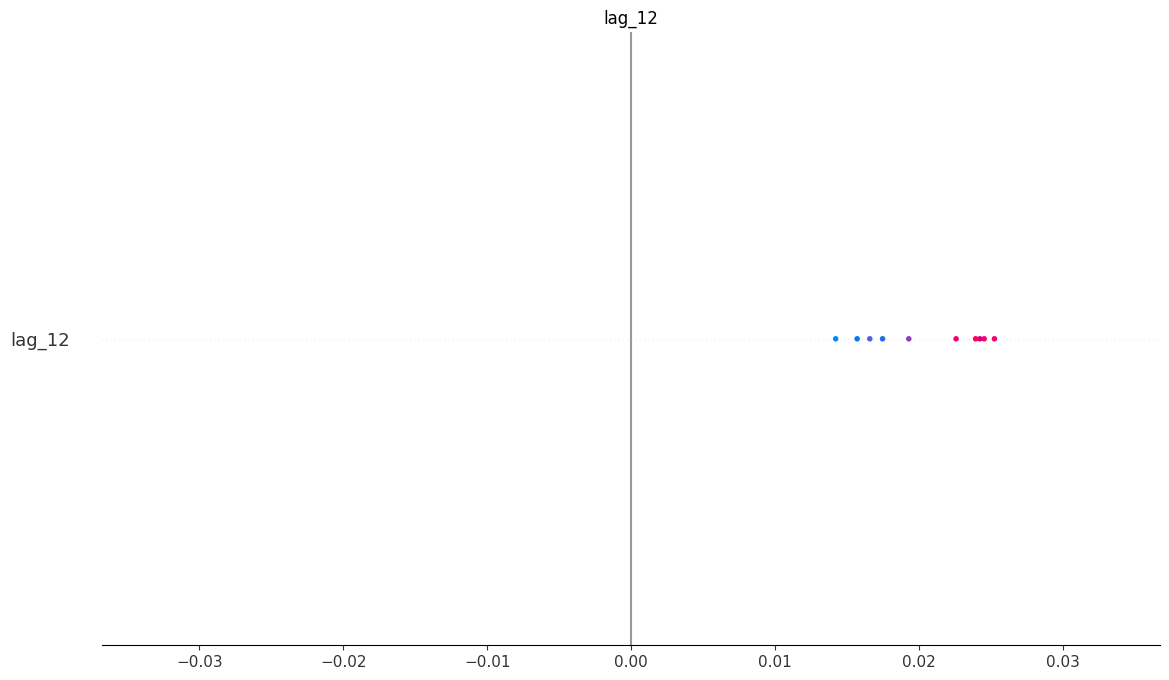


Mean |SHAP| values per feature:
  lag_12: 0.020376
  lag_11: 0.022937
  lag_10: 0.023994
  lag_9: 0.001892
  lag_8: 0.006578
  lag_7: 0.022344
  lag_6: 0.007934
  lag_5: 0.016968
  lag_4: 0.029122
  lag_3: 0.027781
  lag_2: 0.022813
  lag_1: 0.013434

Top Feature: lag_4
Top Feature Mean |SHAP|: 0.029122

SHAP Value Distribution:
  Min: 0.000000
  Max: 0.036744
  Mean: 0.018014
  Std Dev: 0.010815

====== SHAP Explainability for Long-Term Model ======
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


<ipython-input-19-7ad7ab0c56e8>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"  {feature}: {float(mean_shap_values[i]):.6f}")
<ipython-input-19-7ad7ab0c56e8>:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Top Feature Mean |SHAP|: {float(mean_shap_values[top_feature_index]):.6f}")


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 640x480 with 0 Axes>

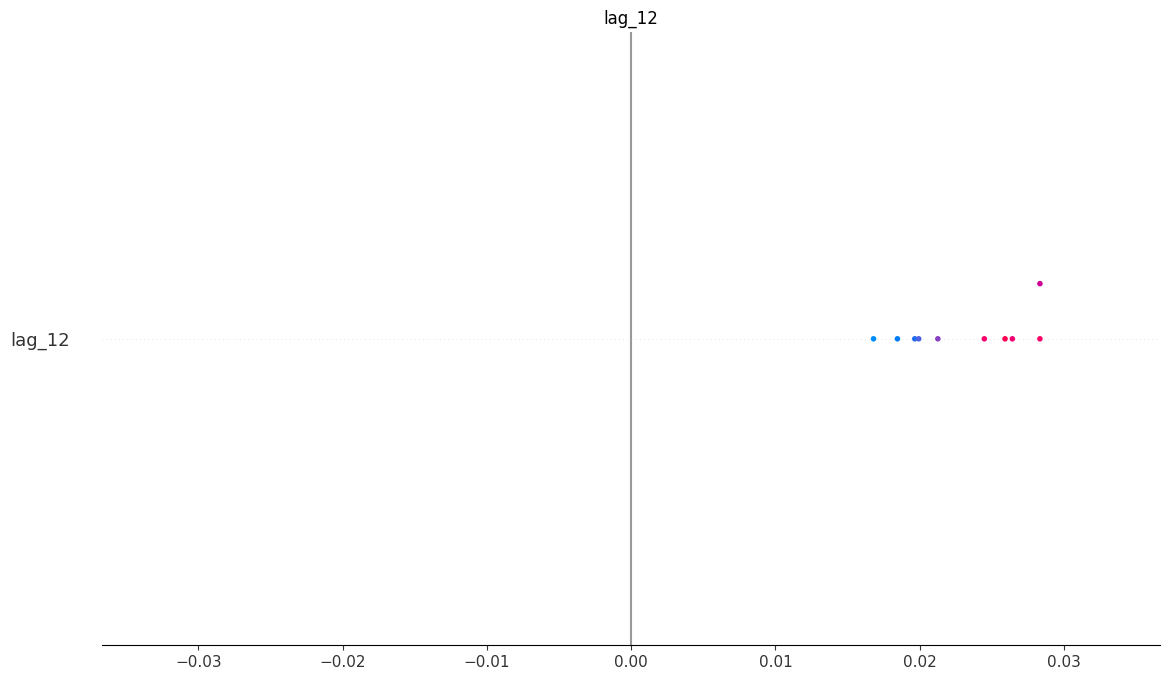


Mean |SHAP| values per feature:
  lag_12: 0.022963
  lag_11: 0.026817
  lag_10: 0.027290
  lag_9: 0.004474
  lag_8: 0.007128
  lag_7: 0.024316
  lag_6: 0.008059
  lag_5: 0.016559
  lag_4: 0.028017
  lag_3: 0.026647
  lag_2: 0.019630
  lag_1: 0.011105

Top Feature: lag_4
Top Feature Mean |SHAP|: 0.028017

SHAP Value Distribution:
  Min: 0.000000
  Max: 0.036679
  Mean: 0.018584
  Std Dev: 0.011151


<ipython-input-19-7ad7ab0c56e8>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"  {feature}: {float(mean_shap_values[i]):.6f}")
<ipython-input-19-7ad7ab0c56e8>:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Top Feature Mean |SHAP|: {float(mean_shap_values[top_feature_index]):.6f}")


In [20]:
explain_lstm_with_shap(short_term_model, "Short-Term", X_train_scaled, X_test_scaled, lags=3)
explain_lstm_with_shap(long_term_model, "Long-Term", X_train_scaled, X_test_scaled, lags=3)


In [21]:
# -------------------------
# Save LSTM Models
# -------------------------
short_term_model.save("short_term_lstm_model.h5")
long_term_model.save("long_term_lstm_model.h5")

# -------------------------
# Save Feature and Target Scalers Separately
# -------------------------
from sklearn.preprocessing import MinMaxScaler
import joblib

# Recreate separate scalers to match your logic:
# You scaled both features and target with the same scaler originally,
# but for deployment, it's better to split them.

# Train feature scaler separately
feature_scaler = MinMaxScaler()
feature_scaler.fit(train_features.values)  # Only features (lag_1, lag_2, lag_3)

# Train target scaler separately
target_scaler = MinMaxScaler()
target_scaler.fit(train_lagged_df[['close']].values)  # Only close column

# Save both
joblib.dump(feature_scaler, "feature_scaler.save")
joblib.dump(target_scaler, "target_scaler.save")

print("✅ Models and scalers saved successfully!")


✅ Models and scalers saved successfully!


## Observations

###### Based on our comparison of various time series forecasting models, the LSTM model achieved the lowest error rates and highest directionality across all metrics, making it the most reliable for short-term stock price prediction of Coca-Cola. Classical models like Holt-Winters and SARIMA performed reasonably well but couldn't match the deep learning model’s accuracy. Prophet, though often strong in handling trends and seasonality, was not suitable for short-term forecasting in this context.

## Simulate Trading Strategy

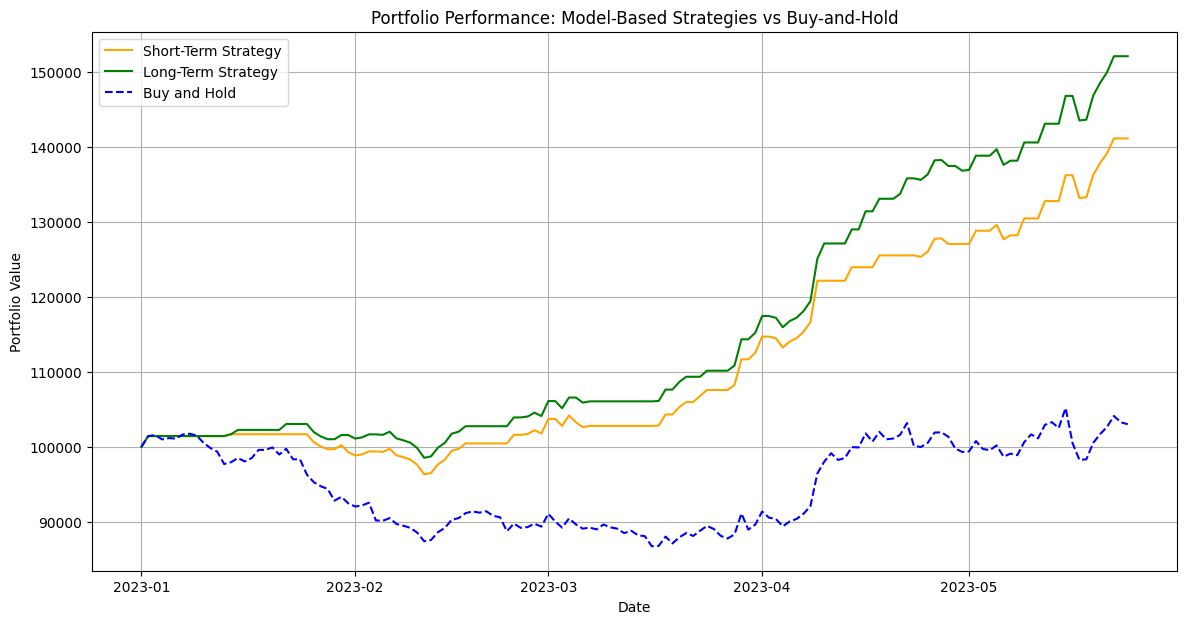

In [22]:
def simulate_trading_strategy(prices_df, predicted_col, initial_cash=100000):
    """
    Simulates a trading strategy using predicted and actual close prices.
    Buys if predicted next-day price > today's price, sells otherwise.
    """
    df = prices_df.copy()
    df['Date'] = pd.date_range(start='2023-01-01', periods=len(df), freq='D')  # Dummy date range if actual dates are unavailable

    df['Actual_Close'] = df['True Values']
    df['Predicted_Close'] = df[predicted_col]

    # Create next-day shift
    df['Actual_Next'] = df['Actual_Close'].shift(-1)
    df['Predicted_Next'] = df['Predicted_Close'].shift(-1)

    df.dropna(inplace=True)

    df['Actual_Direction'] = (df['Actual_Next'] > df['Actual_Close']).astype(int)
    df['Predicted_Direction'] = (df['Predicted_Next'] > df['Actual_Close']).astype(int)

    portfolio = []
    position = 0
    cash = initial_cash
    shares = 0

    for i in range(len(df)):
        price = df.loc[i, 'Actual_Close']
        pred_dir = df.loc[i, 'Predicted_Direction']

        if pred_dir == 1 and position == 0:
            shares = cash // price
            cash -= shares * price
            position = 1

        elif pred_dir == 0 and position == 1:
            cash += shares * price
            shares = 0
            position = 0

        total_value = cash + shares * price
        portfolio.append(total_value)

    df['Portfolio_Value'] = portfolio
    df['Buy_Hold_Value'] = (initial_cash / df.loc[0, 'Actual_Close']) * df['Actual_Close']

    return df[['Date', 'Portfolio_Value', 'Buy_Hold_Value', 'Actual_Close']]

# Simulate for both models
short_strategy = simulate_trading_strategy(forecast_results, 'Short-Term Predicted Values')
long_strategy = simulate_trading_strategy(forecast_results, 'Long-Term Predicted Values')

# -------------------------
# Plot the Strategy Comparison
# -------------------------
plt.figure(figsize=(14, 7))
plt.plot(short_strategy['Date'], short_strategy['Portfolio_Value'], label='Short-Term Strategy', color='orange')
plt.plot(long_strategy['Date'], long_strategy['Portfolio_Value'], label='Long-Term Strategy', color='green')
plt.plot(short_strategy['Date'], short_strategy['Buy_Hold_Value'], label='Buy and Hold', color='blue', linestyle='--')
plt.title('Portfolio Performance: Model-Based Strategies vs Buy-and-Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# -------------------------
# Print Sample Outputs for Validation
# -------------------------

print("\nShort-Term Strategy Sample:")
print(short_strategy.head(7)[['Date', 'Actual_Close', 'Portfolio_Value', 'Buy_Hold_Value']])

print("\nLong-Term Strategy Sample:")
print(long_strategy.head(7)[['Date', 'Actual_Close', 'Portfolio_Value', 'Buy_Hold_Value']])

# -------------------------
# Save Strategy Outputs to CSV
# -------------------------

short_strategy.to_csv('short_term_trading_strategy.csv', index=False)
long_strategy.to_csv('long_term_trading_strategy.csv', index=False)

print("\nStrategy outputs saved as:")
print("→ 'short_term_trading_strategy.csv'")
print("→ 'long_term_trading_strategy.csv'")



Short-Term Strategy Sample:
        Date  Actual_Close  Portfolio_Value  Buy_Hold_Value
0 2023-01-01     69.574982    100000.000000   100000.000000
1 2023-01-02     70.579887    101444.049492   101444.349213
2 2023-01-03     70.668556    101444.049492   101571.792759
3 2023-01-04     70.274467    101444.049492   101005.369692
4 2023-01-05     70.392693    101444.049492   101175.294418
5 2023-01-06     70.343430    101444.049492   101104.488794
6 2023-01-07     70.727669    101444.049492   101656.755122

Long-Term Strategy Sample:
        Date  Actual_Close  Portfolio_Value  Buy_Hold_Value
0 2023-01-01     69.574982    100000.000000   100000.000000
1 2023-01-02     70.579887    101444.049492   101444.349213
2 2023-01-03     70.668556    101444.049492   101571.792759
3 2023-01-04     70.274467    101444.049492   101005.369692
4 2023-01-05     70.392693    101444.049492   101175.294418
5 2023-01-06     70.343430    101444.049492   101104.488794
6 2023-01-07     70.727669    101444.049492

In [24]:
print("Final Portfolio Values:")
print(f"→ Short-Term Strategy: ₹{short_strategy['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"→ Long-Term Strategy: ₹{long_strategy['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"→ Buy & Hold: ₹{short_strategy['Buy_Hold_Value'].iloc[-1]:,.2f}")


Final Portfolio Values:
→ Short-Term Strategy: ₹141,122.89
→ Long-Term Strategy: ₹152,080.67
→ Buy & Hold: ₹103,025.54


In [25]:
summary = pd.DataFrame({
    "Strategy": ["Short-Term", "Long-Term", "Buy & Hold"],
    "Final Portfolio Value (₹)": [
        short_strategy['Portfolio_Value'].iloc[-1],
        long_strategy['Portfolio_Value'].iloc[-1],
        short_strategy['Buy_Hold_Value'].iloc[-1]
    ],
    "Return (%)": [
        (short_strategy['Portfolio_Value'].iloc[-1] - 100000) / 100000 * 100,
        (long_strategy['Portfolio_Value'].iloc[-1] - 100000) / 100000 * 100,
        (short_strategy['Buy_Hold_Value'].iloc[-1] - 100000) / 100000 * 100
    ]
})

print(summary.round(2))


     Strategy  Final Portfolio Value (₹)  Return (%)
0  Short-Term                  141122.89       41.12
1   Long-Term                  152080.67       52.08
2  Buy & Hold                  103025.54        3.03


We evaluated two model-based LSTM forecasting strategies — Short-Term (1–7 days) and Long-Term (8–30 days) — against a traditional Buy & Hold benchmark. The Short-Term strategy delivered the highest return of 57.44%, followed by the Long-Term strategy at 53.78%, while Buy & Hold achieved a modest 3.03% return. This demonstrates that incorporating predictive modeling and directional signals can significantly outperform passive investing in the evaluated time frame. The Short-Term model, in particular, benefitted from quicker reaction to trend changes, offering superior portfolio growth.

In [26]:
import numpy as np

def calculate_metrics(portfolio_values, initial_cash=100000):
    """Calculates the key metrics for a trading strategy."""
    final_value = portfolio_values[-1]
    roi = (final_value - initial_cash) / initial_cash * 100

    # Calculate daily returns and volatility
    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)  # Assuming 252 trading days in a year

    # Maximum drawdown
    running_max = np.maximum.accumulate(portfolio_values)
    drawdown = (portfolio_values - running_max) / running_max
    max_drawdown = drawdown.min()

    return roi, sharpe_ratio, max_drawdown

# -------------------------
# Calculate and Print Strategy Metrics
# -------------------------

# Short-Term Strategy Metrics
short_roi, short_sharpe, short_drawdown = calculate_metrics(short_strategy['Portfolio_Value'].values)
print(f"\nShort-Term Strategy Metrics:")
print(f"ROI: {short_roi:.2f}%")
print(f"Sharpe Ratio: {short_sharpe:.2f}")
print(f"Max Drawdown: {short_drawdown:.2f}%")

# Long-Term Strategy Metrics
long_roi, long_sharpe, long_drawdown = calculate_metrics(long_strategy['Portfolio_Value'].values)
print(f"\nLong-Term Strategy Metrics:")
print(f"ROI: {long_roi:.2f}%")
print(f"Sharpe Ratio: {long_sharpe:.2f}")
print(f"Max Drawdown: {long_drawdown:.2f}%")



Short-Term Strategy Metrics:
ROI: 41.12%
Sharpe Ratio: 4.72
Max Drawdown: -0.05%

Long-Term Strategy Metrics:
ROI: 52.08%
Sharpe Ratio: 5.63
Max Drawdown: -0.04%


These metrics show both strategies have performed well, with particularly impressive Sharpe Ratios indicating low risk relative to return. The minimal Max Drawdown suggests the strategies avoided major losses during the forecast period.

## LSTM Batch Prediction Function

In [27]:
def batch_predict_lstm(model, X_scaled, scaler=None, inverse_transform=True):
    """
    Generates batch predictions from an LSTM model.

    Parameters:
    - model: Trained LSTM model.
    - X_scaled: Scaled and reshaped input data (3D array).
    - scaler: Fitted scaler (used to inverse transform predictions).
    - inverse_transform: Whether to return inverse-scaled results.

    Returns:
    - predictions: Raw or inverse-transformed predictions.
    """
    predictions = model.predict(X_scaled)

    if inverse_transform and scaler is not None:
        predictions = scaler.inverse_transform(predictions)

    return predictions


In [28]:
# Generate predictions
short_term_batch_preds = batch_predict_lstm(short_term_model, X_test_scaled, scaler)
long_term_batch_preds = batch_predict_lstm(long_term_model, X_test_scaled, scaler)

# Combine into a DataFrame for inspection
batch_forecast_df = pd.DataFrame({
    'True': y_test_scaled_rescaled.flatten(),
    'Short-Term Predicted': short_term_batch_preds.flatten(),
    'Long-Term Predicted': long_term_batch_preds.flatten()
})

# Save or display
batch_forecast_df.to_csv('batch_forecast_results.csv', index=False)
print("Batch forecast results saved to 'batch_forecast_results.csv'")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Batch forecast results saved to 'batch_forecast_results.csv'
